# Trénovanie modelu na základe DST indexu, F10_indexu a BZ_GSM 48h dopredu 6 dozadu
Súbor: 6_48_pridane_atr.ipynb

Program: Hospodárska informatika

Vypracovala: Bc. Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [ ]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 32.9 MB/s eta 0:00:0000:0100:01


### Kontrola kapacity servera

In [2]:
!nvidia-smi

Tue Mar 14 08:41:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K40c          Off  | 00000000:01:00.0 Off |                    0 |
| 29%   62C    P0    75W / 235W |      0MiB / 11441MiB |     66%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import knižníc

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [2]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
           'DST',
            'F10_INDEX',
            'BZ_GSM',
            'DST+48']
test = test[features]
train = train[features]
train = train.dropna()
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST+48'
predicators = ['DST',
            'F10_INDEX',
            'BZ_GSM']

y_col='DST+48'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train[predicators].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[predicators].values.copy()
y_test = test[y_col].values.copy()
X_test = test[predicators].values.copy()

In [3]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [4]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  753
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [5]:
inputs = Input(shape=(6,3)) #(kolko hodinove je okno, kolko je features v train)
c = Bidirectional((LSTM(128, input_shape=(X_train.shape[0], X_train.shape[1]), return_sequences=True, dropout=0.1,recurrent_dropout=0.1)))(inputs)
c = LSTM(128, input_shape=(X_train.shape[0], X_train.shape[1]), return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2023-03-14 08:41:57.708685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 08:41:58.204178: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10787 MB memory:  -> device: 0, name: Tesla K40c, pci bus id: 0000:01:00.0, compute capability: 3.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           135168    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [6]:
inputs = Input(shape=(6,3)) #(kolko hodinove je okno, kolko je features v train)
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(3, activation='linear'))(c)
output = Flatten()(c)
output = Dense(3, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 6, 256)           135168    
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed_1 (TimeDis  (None, 6, 3)             387       
 tributed)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 18)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 57  

In [7]:
# callbacks
saved_model = "6_48_pridane_atr.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [8]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20
  1/753 [..............................] - ETA: 1:19:05 - loss: 226.8846 - mae: 11.8178

2023-03-14 08:42:06.117766: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


753/753 [==============================] - ETA: 0s - loss: 406.5894 - mae: 13.5779
Epoch 1: val_mae improved from inf to 15.25847, saving model to 6_48_pridane_atr.hdf5
753/753 [==============================] - 125s 158ms/step - loss: 406.5894 - mae: 13.5779 - val_loss: 572.5217 - val_mae: 15.2585
Epoch 2/20
753/753 [==============================] - ETA: 0s - loss: 382.5600 - mae: 13.2208
Epoch 2: val_mae did not improve from 15.25847
753/753 [==============================] - 118s 157ms/step - loss: 382.5600 - mae: 13.2208 - val_loss: 574.2241 - val_mae: 15.6063
Epoch 3/20
753/753 [==============================] - ETA: 0s - loss: 379.7545 - mae: 13.1916
Epoch 3: val_mae improved from 15.25847 to 14.91969, saving model to 6_48_pridane_atr.hdf5
753/753 [==============================] - 118s 157ms/step - loss: 379.7545 - mae: 13.1916 - val_loss: 564.0732 - val_mae: 14.9197
Epoch 4/20
753/753 [==============================] - ETA: 0s - loss: 376.6832 - mae: 13.1130
Epoch 4: val_mae d

In [4]:
# load best model
model = keras.models.load_model('6_48_pridane_atr.hdf5')

2023-04-18 12:30:36.578223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 12:30:37.142356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 122 MB memory:  -> device: 0, name: Tesla K40c, pci bus id: 0000:01:00.0, compute capability: 3.5


In [5]:
# prediction
y_pred = model.predict(test_generator)

  9/607 [..............................] - ETA: 8s 

2023-04-18 12:30:41.951446: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


607/607 [==============================] - 12s 16ms/step


In [6]:
y_pred

array([[  1.523126 ,   1.7997501,   1.5635931],
       [  1.7520623,   2.0875418,   1.8575394],
       [  1.9829582,   2.288484 ,   2.0291138],
       ...,
       [-21.050861 , -22.024057 , -22.181545 ],
       [-24.04103  , -22.04472  , -22.38325  ],
       [-20.210772 , -20.352922 , -20.905638 ]], dtype=float32)

In [17]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred[:,2] <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[117277   7404]
 [ 21042   9530]]


In [18]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89    124681
           1       0.56      0.31      0.40     30572

    accuracy                           0.82    155253
   macro avg       0.71      0.63      0.65    155253
weighted avg       0.79      0.82      0.80    155253



In [20]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred[:,2].reshape(-1)})

In [21]:
df

,time,y_true,y_predict
6,2004-07-22 04:00:00,-8.0,1.563593
7,2004-07-22 05:00:00,-6.0,1.857539
8,2004-07-22 06:00:00,-6.0,2.029114
9,2004-07-22 07:00:00,-7.0,1.863428
10,2004-07-22 08:00:00,-4.0,1.405443
...,...,...,...
155254,2022-04-28 20:00:00,15.0,-20.602690
155255,2022-04-28 21:00:00,15.0,-22.023718
155256,2022-04-28 22:00:00,12.0,-22.181545
155257,2022-04-28 23:00:00,11.0,-22.383249


In [22]:
df.describe()

,y_true,y_predict
count,155253.000000,155253.000000
mean,-9.801968,-10.573305
std,16.319787,7.549118
min,-374.000000,-45.299843
25%,-16.000000,-15.258624
50%,-7.000000,-9.737543
75%,0.000000,-5.073156
max,77.000000,3.335574


<AxesSubplot: >

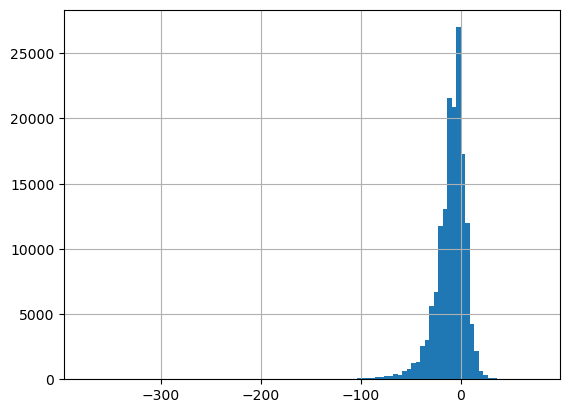

In [23]:
df["y_true"].hist(bins=100)

In [ ]:
df["y_predict"].hist(bins=100)

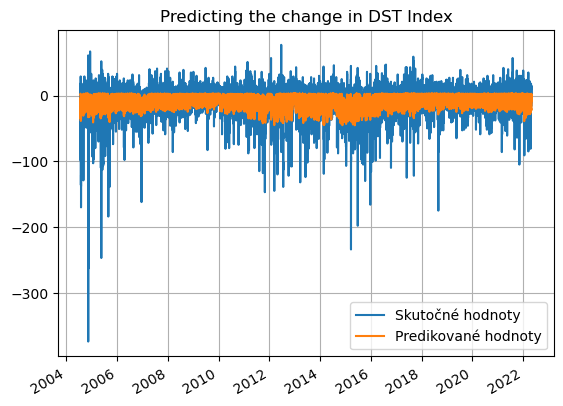

In [24]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [25]:
df.to_csv('predikcie_6_48_prid_atr.csv')

In [ ]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

In [26]:
TN = cm[0,0] 
print(TN)
FP = cm[0,1]
print(FP)
FN = cm[1,0] 
print(FN)
TP = cm[1,1] 
print(TP)

117277
7404
21042
9530


In [27]:
from sklearn.metrics import *
TN = cm[0,0] 
print("TN={}".format(TN))
FP = cm[0,1]
print("FP={}".format(FP))
FN = cm[1,0] 
print("FN={}".format(FN))
TP = cm[1,1] 
print("TP={}".format(TP))
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR={}".format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("TNR={}".format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV={}".format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV={}".format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR={}".format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print("FNR={}".format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR={}".format(FDR))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC={}".format(ACC))
fpr, tpr, threshold = roc_curve(y_test2, y_pred2)
AUC = auc(fpr, tpr)
print("AUC={}".format(AUC))
MCC = matthews_corrcoef(y_test2, y_pred2)
print("MCC={}".format(MCC))

TN=117277
FP=7404
FN=21042
TP=9530
TPR=0.3117231453617689
TNR=0.9406164531885371
PPV=0.5627731191685367
NPV=0.847873394110715
FPR=0.05938354681146285
FNR=0.6882768546382311
FDR=0.4372268808314633
ACC=0.8167764874108713
AUC=0.626169799275153
MCC=0.32190429681346183
